<a href="https://colab.research.google.com/github/ben-wycliff/dl-final-exam/blob/main/torch_experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/School/MSc Computer Science/Sem2 - (Ben Wycliff) - Year 1/Deep Learning/deep learning final exam/data.zip"

# Import Libraries

In [ ]:
import os
import torch
import torchvision
from torchvision.transforms import transforms

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

# Prepare Data

In [ ]:
# Set the path to your dataset
train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/val'

# Set the input image dimensions
input_shape = (256, 256)

# Set the number of classes
num_classes = 6

# Define transformations for data normalization and grayscale conversion
data_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

# Create datasets for training, validation, and testing
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=data_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=data_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=data_transforms)

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=63, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model

In [ ]:
# Define the convolutional neural network model
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(32*32*128, 32),
    nn.ReLU(),
    nn.Linear(32, num_classes),
    nn.Softmax(dim=1)
)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up TensorBoard writer
log_dir = 'logs'
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

# Train

In [ ]:
train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

best_valid_acc = 0.0
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    train_running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy values
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy for the epoch
    train_epoch_loss = train_running_loss / len(train_loader)
    train_epoch_acc = train_correct / train_total

    # Append training loss and accuracy values to the history lists
    train_loss_history.append(train_epoch_loss)
    train_acc_history.append(train_epoch_acc)

    # Validation step
    model.eval()
    valid_correct = 0
    valid_total = 0
    valid_running_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update validation loss and accuracy values
            valid_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy for the epoch
    valid_epoch_loss = valid_running_loss / len(val_loader)
    valid_epoch_acc = valid_correct / valid_total

    # Append validation loss and accuracy values to the history lists
    valid_loss_history.append(valid_epoch_loss)
    valid_acc_history.append(valid_epoch_acc)

    # Print the loss and accuracy for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f}, '
          f'Valid Loss: {valid_epoch_loss:.4f}, Valid Acc: {valid_epoch_acc:.4f}')

    # Check if the current model's validation accuracy is better than the previous best accuracy
    if valid_epoch_acc > best_valid_acc:
        best_valid_acc = valid_epoch_acc
        best_model_weights = model.state_dict()

print('Training finished.')

Epoch [1/40], Train Loss: 1.5734, Train Acc: 0.4630, Valid Loss: 1.4888, Valid Acc: 0.5417
Epoch [2/40], Train Loss: 1.4517, Train Acc: 0.5913, Valid Loss: 1.3953, Valid Acc: 0.6389
Epoch [3/40], Train Loss: 1.3720, Train Acc: 0.6704, Valid Loss: 1.3332, Valid Acc: 0.7083
Epoch [4/40], Train Loss: 1.3063, Train Acc: 0.7385, Valid Loss: 1.3098, Valid Acc: 0.7250
Epoch [5/40], Train Loss: 1.2648, Train Acc: 0.7796, Valid Loss: 1.2760, Valid Acc: 0.7639
Epoch [6/40], Train Loss: 1.2119, Train Acc: 0.8320, Valid Loss: 1.2474, Valid Acc: 0.7889
Epoch [7/40], Train Loss: 1.1847, Train Acc: 0.8597, Valid Loss: 1.2255, Valid Acc: 0.8139
Epoch [8/40], Train Loss: 1.1682, Train Acc: 0.8763, Valid Loss: 1.2352, Valid Acc: 0.8056
Epoch [9/40], Train Loss: 1.1492, Train Acc: 0.8947, Valid Loss: 1.2088, Valid Acc: 0.8306
Epoch [10/40], Train Loss: 1.1397, Train Acc: 0.9041, Valid Loss: 1.2010, Valid Acc: 0.8389
Epoch [11/40], Train Loss: 1.1266, Train Acc: 0.9170, Valid Loss: 1.1943, Valid Acc: 0.85

In [ ]:
# Evaluate the model on the validation set
model.eval()
val_predictions = []
val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        val_predictions.extend(predicted.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

# Convert prediction labels and true labels to numpy arrays
val_predictions = np.array(val_predictions)
val_labels = np.array(val_labels)

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        60
           1       0.93      0.87      0.90        60
           2       0.82      1.00      0.90        60
           3       0.92      0.95      0.93        60
           4       1.00      0.90      0.95        60
           5       0.95      0.92      0.93        60

    accuracy                           0.91       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.92      0.91      0.91       360

Confusion Matrix:
[[51  0  5  1  0  3]
 [ 1 52  4  3  0  0]
 [ 0  0 60  0  0  0]
 [ 2  0  1 57  0  0]
 [ 3  0  2  1 54  0]
 [ 0  4  1  0  0 55]]


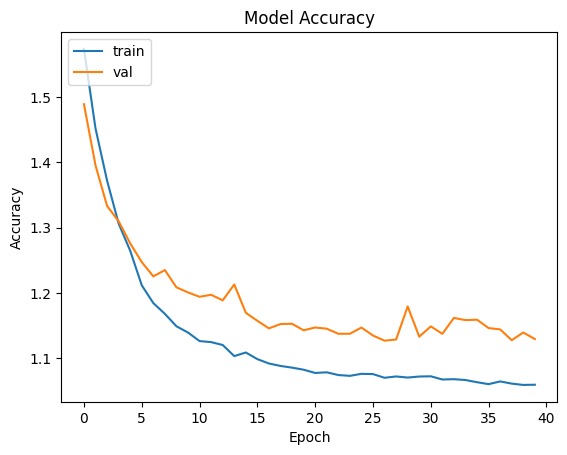

In [ ]:
# Print classification report and confusion matrix
print("Validation Classification Report:")
print(classification_report(val_labels, val_predictions))
print("Confusion Matrix:")
print(confusion_matrix(val_labels, val_predictions))

# Plot learning curves
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

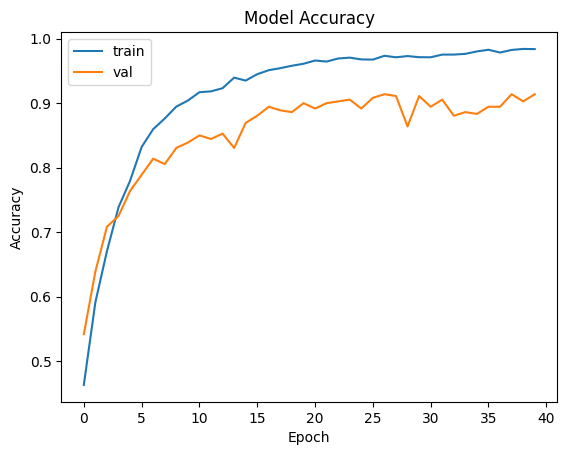

In [ ]:
# Plot learning curves
plt.plot(train_acc_history)
plt.plot(valid_acc_history)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()